<a href="https://colab.research.google.com/github/NadaTiyasa/Bengkod_NadaTiyasa_14217/blob/main/Bengkod_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nada Tiyasa Salsabela (A11.2022.14217)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [ ]:
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ObesityDataSet.csv')

Mounted at /content/drive


# 1. Exploratory Data Analysis (EDA)

In [ ]:
# =========================================================================
#       Tampilan beberapa baris pertama dan informasi umum dataset
# =========================================================================
print("<3<3<3 Beberapa Baris Pertama <3<3<3")
print(df.head())
print("\n<3<3<3 Dimensi Dataset <3<3<3")
print(f"Jumlah baris: {df.shape[0]}")
print(f"Jumlah kolom: {df.shape[1]}")
print("\n<3<3<3 Deskripsi Statistik Dataset <3<3<3")
print(df.describe(include='all'))
print("\n<3<3<3 Tipe Data Setiap Kolom <3<3<3")
print(df.dtypes)

<3<3<3 Beberapa Baris Pertama <3<3<3
  Age  Gender Height Weight        CALC FAVC FCVC NCP  SCC SMOKE CH2O  \
0  21  Female   1.62     64          no   no    2   3   no    no    2   
1  21  Female   1.52     56   Sometimes   no    3   3  yes   yes    3   
2  23    Male    1.8     77  Frequently   no    2   3   no    no    2   
3  27    Male    1.8     87  Frequently   no    3   3   no    no    2   
4  22    Male   1.78   89.8   Sometimes   no    2   1   no    no    2   

  family_history_with_overweight FAF TUE       CAEC                 MTRANS  \
0                            yes   0   1  Sometimes  Public_Transportation   
1                            yes   3   0  Sometimes  Public_Transportation   
2                            yes   2   1  Sometimes  Public_Transportation   
3                             no   2   0  Sometimes                Walking   
4                             no   0   0  Sometimes  Public_Transportation   

            NObeyesdad  
0        Normal_Weight  
1    

In [ ]:
# =========================================================================
#             Cek Missing Value, Duplikat, dan Nilai Unik
# =========================================================================
print("\n<3<3<3 Jumlah Missing Values Tiap Kolom <3<3<3")
print(df.isnull().sum())
print("\n<3<3<3 Jumlah Duplikat <3<3<3")
print(df.duplicated().sum())
print("\n<3<3<3 Jumlah Nilai Unik Tiap Kolom <3<3<3")
print(df.nunique())


<3<3<3 Jumlah Missing Values Tiap Kolom <3<3<3
Age                               14
Gender                             9
Height                            12
Weight                            11
CALC                               5
FAVC                              11
FCVC                               8
NCP                               12
SCC                               10
SMOKE                              5
CH2O                               6
family_history_with_overweight    13
FAF                                8
TUE                                9
CAEC                              11
MTRANS                             6
NObeyesdad                         0
dtype: int64

<3<3<3 Jumlah Duplikat <3<3<3
18

<3<3<3 Jumlah Nilai Unik Tiap Kolom <3<3<3
Age                               1394
Gender                               3
Height                            1562
Weight                            1518
CALC                                 5
FAVC                                 

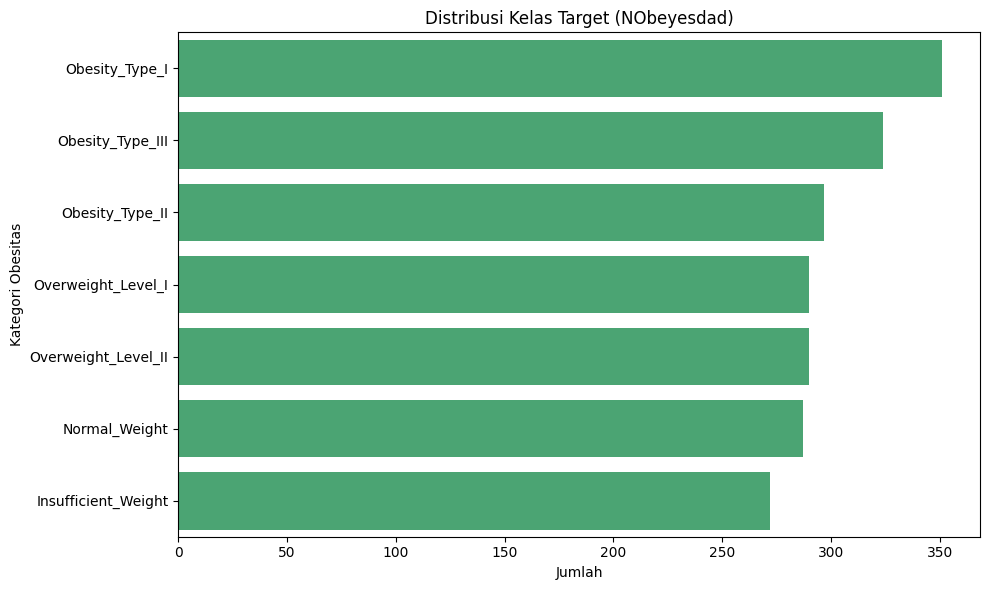

In [ ]:
# =========================================================================
#                   Visualisasi Distribusi Kelas Target
# =========================================================================
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='NObeyesdad', order=df['NObeyesdad'].value_counts().index, color='mediumseagreen')
plt.title('Distribusi Kelas Target (NObeyesdad)')
plt.xlabel('Jumlah')
plt.ylabel('Kategori Obesitas')
plt.tight_layout()
plt.show()

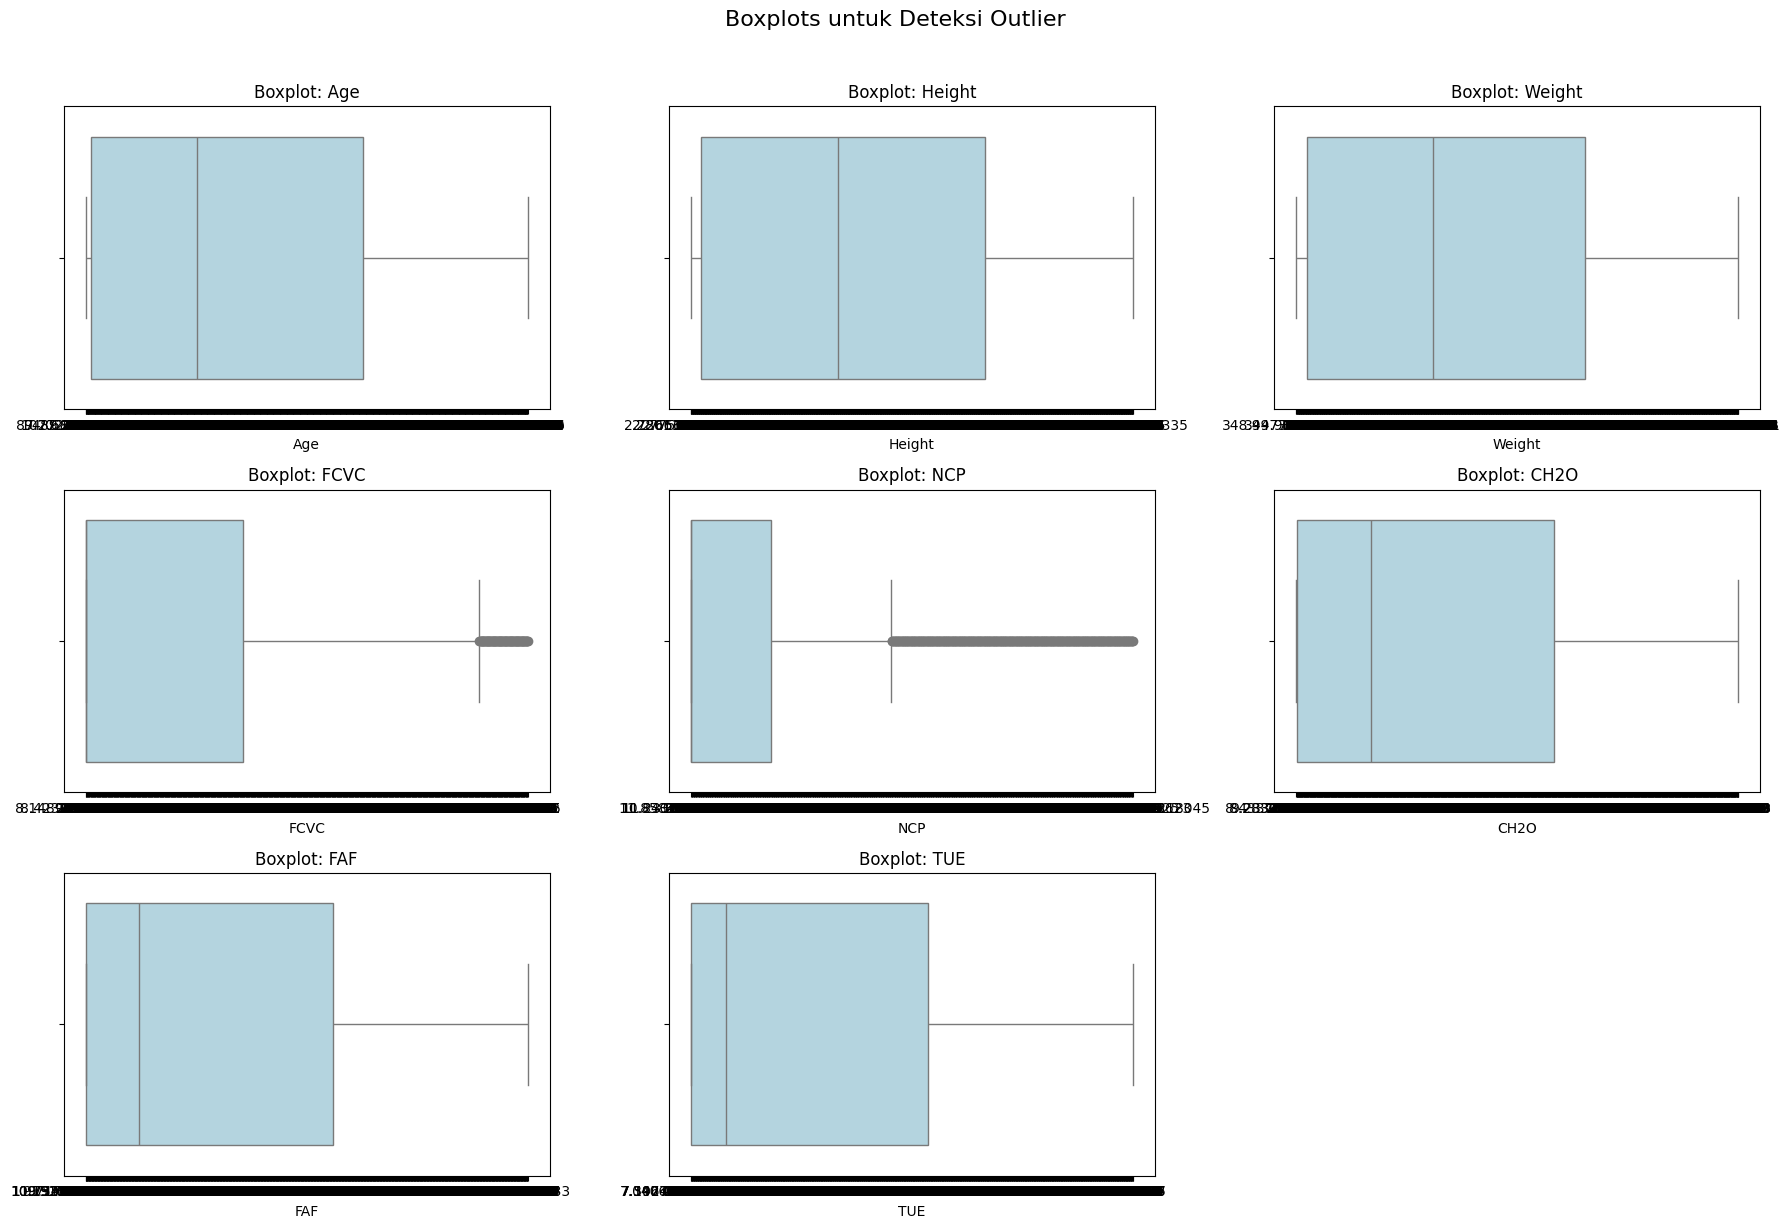

In [ ]:
# =========================================================================
#                     Boxplot untuk Deteksi Outlier
# =========================================================================
numeric_columns = ["Age", "Height", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]

plt.figure(figsize=(18, 12))
for i, col in enumerate(numeric_columns):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x=df[col], color='lightblue')
    plt.title(f'Boxplot: {col}')
    plt.tight_layout()

plt.suptitle('Boxplots untuk Deteksi Outlier', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

Dataset obesitas terdiri dari 2.111 baris dan 17 kolom dengan 7 kategori pada target NObeyesdad, didominasi oleh Obesity_Type_I. Terdapat missing values di hampir semua kolom, serta 18 data duplikat yang perlu dihapus. Beberapa kolom numerik masih bertipe objek karena format penulisan tidak konsisten. Dataset juga menunjukkan adanya outlier, terutama pada kolom NCP, FCVC, FAF, dan TUE, yang perlu ditangani untuk menjaga kualitas pemodelan. Secara keseluruhan, dataset memerlukan pembersihan lanjutan sebelum digunakan dalam machine learning.









# 2. Preprocessing Data

In [ ]:
print("Daftar kolom dalam DataFrame:")
print(df.columns.tolist())

Daftar kolom dalam DataFrame:
['Age', 'Gender', 'Height', 'Weight', 'CALC', 'FAVC', 'FCVC', 'NCP', 'SCC', 'SMOKE', 'CH2O', 'family_history_with_overweight', 'FAF', 'TUE', 'CAEC', 'MTRANS', 'NObeyesdad']


In [ ]:
# =========================================================================
# Tangani missing values, error, duplikasi, dan outlier di setiap kolom.
# =========================================================================
df = df.copy()
numeric_columns = ["Age", "Height", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]

# Ganti koma jadi titik, ubah '?' jadi NaN, ubah ke float
for col in numeric_columns:
    df[col] = df[col].astype(str).str.replace(",", ".", regex=False)
    df[col] = df[col].replace("?", np.nan)
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Tampilkan jumlah missing value setelah konversi
print("Missing values setelah konversi:")
print(df[numeric_columns].isnull().sum())

# Hapus duplikat
df = df.drop_duplicates()

# Isi missing values: median untuk numerik, mode untuk kategorikal
for col in df.columns:
    if df[col].dtype == object:
        mode_val = df[col].mode()[0]
        df.loc[:, col] = df[col].fillna(mode_val)
    else:
        median_val = df[col].median()
        df.loc[:, col] = df[col].fillna(median_val)

# Fungsi hapus outlier dengan IQR
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[col] >= lower) & (df[col] <= upper)]

# Terapkan outlier removal untuk setiap kolom numerik
for col in numeric_columns:
    df = remove_outliers(df, col).copy()  # .copy() untuk mencegah warning pada loop selanjutnya

# Tampilkan hasil akhir
print("\nJumlah data setelah pembersihan:", df.shape)
print("\nContoh 5 data teratas:")
print(df.head())

Missing values setelah konversi:
Age       22
Height    22
Weight    19
FCVC      18
NCP       22
CH2O      15
FAF       19
TUE       15
dtype: int64

Jumlah data setelah pembersihan: (1317, 17)

Contoh 5 data teratas:
    Age  Gender  Height  Weight        CALC FAVC  FCVC  NCP  SCC SMOKE  CH2O  \
0  21.0  Female    1.62    64.0          no   no   2.0  3.0   no    no   2.0   
1  21.0  Female    1.52    56.0   Sometimes   no   3.0  3.0  yes   yes   3.0   
2  23.0    Male    1.80    77.0  Frequently   no   2.0  3.0   no    no   2.0   
3  27.0    Male    1.80    87.0  Frequently   no   3.0  3.0   no    no   2.0   
5  29.0    Male    1.62    53.0   Sometimes  yes   2.0  3.0   no    no   2.0   

  family_history_with_overweight  FAF  TUE       CAEC                 MTRANS  \
0                            yes  0.0  1.0  Sometimes  Public_Transportation   
1                            yes  3.0  0.0  Sometimes  Public_Transportation   
2                            yes  2.0  1.0  Sometimes  Publi

In [ ]:
# =========================================================================
#                     Ubah data kategori menjadi numerik
# =========================================================================
target_col = "NObeyesdad" # Tentukan kolom target

# Ambil kolom kategorikal selain target
cat_cols = [col for col in df.select_dtypes(include='object').columns if col != target_col]

# Label encode semua fitur kategorikal
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Label encode target
target_encoder = LabelEncoder()
df[target_col] = target_encoder.fit_transform(df[target_col])

# Simpan hasil ke df_cleaned
df_cleaned = df.copy()

# Distribusi kelas target (dalam persentase)
class_distribution = df_cleaned[target_col].value_counts(normalize=True)

# ==================== Tampilkan Ringkasan ====================
print(" Ukuran dataset setelah preprocessing:", df_cleaned.shape)
print("\n Jumlah nilai kosong per kolom:")
print(df_cleaned.isnull().sum())

print("\n Distribusi kelas target (dalam persentase):")
print(class_distribution)


 Ukuran dataset setelah preprocessing: (1317, 17)

 Jumlah nilai kosong per kolom:
Age                               0
Gender                            0
Height                            0
Weight                            0
CALC                              0
FAVC                              0
FCVC                              0
NCP                               0
SCC                               0
SMOKE                             0
CH2O                              0
family_history_with_overweight    0
FAF                               0
TUE                               0
CAEC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

 Distribusi kelas target (dalam persentase):
NObeyesdad
4    0.238421
3    0.153379
1    0.143508
2    0.142749
6    0.119210
5    0.105543
0    0.097191
Name: proportion, dtype: float64


In [ ]:
# =========================================================================
#             Tentukan apakah semua feature perlu digunakan.
# =========================================================================
correlation = df.corr(numeric_only=True)["NObeyesdad"].sort_values(ascending=False)
print("Korelasi fitur dengan target:")
print(correlation)

# Buang fitur dengan korelasi rendah / NaN
drop_cols = ["Height", "SMOKE", "MTRANS", "TUE", "NCP"]
df = df.drop(columns=drop_cols, errors='ignore')

# Pisahkan fitur dan target
X = df.drop("NObeyesdad", axis=1)
y = df["NObeyesdad"]

Korelasi fitur dengan target:
NObeyesdad                        1.000000
Weight                            0.391996
family_history_with_overweight    0.328130
CAEC                              0.279007
Age                               0.253998
CH2O                              0.111247
FCVC                              0.105149
FAVC                              0.080324
MTRANS                           -0.003981
Height                           -0.009105
SMOKE                            -0.035481
TUE                              -0.051704
Gender                           -0.056229
SCC                              -0.104117
FAF                              -0.143359
NCP                              -0.154478
CALC                             -0.168834
Name: NObeyesdad, dtype: float64


In [ ]:
# =========================================================================
#           Atasi ketidakseimbangan kelas data menggunakan SMOTE
# =========================================================================
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Tampilkan distribusi kelas sebelum dan sesudah SMOTE
print("\nDistribusi kelas sebelum SMOTE:")
print(pd.Series(y).value_counts())
print("\nDistribusi kelas sesudah SMOTE:")
print(pd.Series(y_resampled).value_counts())


Distribusi kelas sebelum SMOTE:
NObeyesdad
4    314
3    202
1    189
2    188
6    157
5    139
0    128
Name: count, dtype: int64

Distribusi kelas sesudah SMOTE:
NObeyesdad
1    314
5    314
2    314
6    314
3    314
0    314
4    314
Name: count, dtype: int64


In [ ]:
# =========================================================================
#                           Standarisasi data.
# =========================================================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

Dari hasil preprocessing dataset ini, dapat disimpulkan bahwa data sudah bersih dari nilai kosong setelah penanganan missing values dan konversi numerik. Dataset yang semula memiliki 17 kolom berhasil disederhanakan menjadi 12 fitur relevan dengan menghapus fitur yang korelasinya rendah terhadap target. Distribusi kelas target yang awalnya tidak seimbang berhasil diseimbangkan menggunakan SMOTE, sehingga setiap kelas memiliki jumlah data yang sama yaitu 314 sampel. Proses ini penting untuk menghindari bias model terhadap kelas mayoritas. Korelasi fitur menunjukkan bahwa fitur seperti berat badan (Weight), riwayat keluarga dengan overweight, dan beberapa variabel lain memiliki kontribusi positif terhadap target obesitas, sementara fitur seperti jenis kelamin, aktivitas fisik, dan pola makan memiliki korelasi negatif.